# WESAD 
    TODO:
        - standardize data (by subject)
        - add early stop
check this link: https://github.com/MITMediaLabAffectiveComputing/eda-explorer

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import torch
import torch.nn as nn

class StressNet(nn.Module):
    def __init__(self):
        super(StressNet, self).__init__()
        self.fc = nn.Sequential(
                        nn.Linear(16, 64),
                        nn.ReLU(),
                        nn.Linear(64, 128),
                        nn.ReLU(),
                        nn.Linear(128, 3),
                        nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        return self.fc(x)

In [2]:
import torch
import os
import warnings
warnings.filterwarnings('ignore')
from torch.utils.data import Dataset

class WESADDataset(Dataset):
    def __init__(self):
        self.dataframe = pd.read_csv('m9_feats3.csv', index_col=0)
        self.labels = self.dataframe['label'].values
        self.dataframe.drop('label', axis=1, inplace=True)
        
    def __getitem__(self, idx):
        x = self.dataframe.iloc[idx].values
        y = self.labels[idx]
        return torch.Tensor(x), y

    def __len__(self):
        return len(self.dataframe)

In [3]:
from torch.utils.data.sampler import SubsetRandomSampler

validation_indices = []

def get_training_and_validation_loaders(dataset, batch_size = 16, validation_split = .2):
    
    shuffle_dataset = True
    random_seed = 8

    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))

    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
        
    train_indices, val_indices = indices[split:], indices[:split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=valid_sampler)
    #
    validation_indices = val_indices
    
    return train_loader, validation_loader       

In [4]:
dataset = WESADDataset()

batch_size = 15

train_loader, validation_loader = get_training_and_validation_loaders(dataset, batch_size=batch_size)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 1000
learning_rate = 1e-4
model = StressNet().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
loss_list = []
acc_list = []
train_losses = []
train_accuracies = []
train_losses2 = []
#
for epoch in range(num_epochs):
        
    # Train:   
    total = 0
    correct = 0
    trainlosses = []
    
    for batch_index, (images, labels) in enumerate(train_loader):
        
        # Send to GPU (device)
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images.float())
        
        # Loss
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        trainlosses.append(loss.item())
        
        # Compute accuracy
        _, argmax = torch.max(outputs, 1)
        correct += (labels == argmax).sum().item() #.mean()
        total += len(labels)
        
    train_losses.append( np.mean(trainlosses) )
    train_accuracies.append( correct/total )
    train_losses2.extend(trainlosses)
                        
    with torch.no_grad():
        
        losses = []
        total = 0
        correct = 0
    
        for images, labels in validation_loader:
            # 
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images.float())
            
            loss = criterion(outputs, labels)
        
            # Compute accuracy
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item() #.mean()
            total += len(labels)
            
            losses.append(loss.item())
    
        acc = np.round(correct/total, 3)
        loss = np.mean(losses)
        
        acc_list.append(acc)
        loss_list.append(loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(losses):.4}, Acc: {correct/total:.2}')

Epoch [1/1000], Loss: 2.008, Acc: 0.49
Epoch [2/1000], Loss: 1.331, Acc: 0.47
Epoch [3/1000], Loss: 1.212, Acc: 0.46
Epoch [4/1000], Loss: 1.338, Acc: 0.49
Epoch [5/1000], Loss: 1.342, Acc: 0.46
Epoch [6/1000], Loss: 1.021, Acc: 0.51
Epoch [7/1000], Loss: 1.031, Acc: 0.46
Epoch [8/1000], Loss: 0.9284, Acc: 0.5
Epoch [9/1000], Loss: 0.9883, Acc: 0.51
Epoch [10/1000], Loss: 0.9388, Acc: 0.56
Epoch [11/1000], Loss: 0.9473, Acc: 0.54
Epoch [12/1000], Loss: 1.12, Acc: 0.5
Epoch [13/1000], Loss: 0.9102, Acc: 0.57
Epoch [14/1000], Loss: 0.8956, Acc: 0.56
Epoch [15/1000], Loss: 0.9659, Acc: 0.54
Epoch [16/1000], Loss: 0.9561, Acc: 0.5
Epoch [17/1000], Loss: 0.9606, Acc: 0.54
Epoch [18/1000], Loss: 0.952, Acc: 0.59
Epoch [19/1000], Loss: 0.8905, Acc: 0.6
Epoch [20/1000], Loss: 0.9162, Acc: 0.57
Epoch [21/1000], Loss: 1.008, Acc: 0.54
Epoch [22/1000], Loss: 0.9624, Acc: 0.57
Epoch [23/1000], Loss: 1.081, Acc: 0.54
Epoch [24/1000], Loss: 0.9412, Acc: 0.6
Epoch [25/1000], Loss: 0.9987, Acc: 0.56
E

Epoch [205/1000], Loss: 0.9399, Acc: 0.59
Epoch [206/1000], Loss: 0.8882, Acc: 0.65
Epoch [207/1000], Loss: 0.8555, Acc: 0.69
Epoch [208/1000], Loss: 0.8373, Acc: 0.66
Epoch [209/1000], Loss: 0.9327, Acc: 0.6
Epoch [210/1000], Loss: 1.109, Acc: 0.6
Epoch [211/1000], Loss: 0.9229, Acc: 0.63
Epoch [212/1000], Loss: 0.8144, Acc: 0.68
Epoch [213/1000], Loss: 0.926, Acc: 0.57
Epoch [214/1000], Loss: 0.9187, Acc: 0.62
Epoch [215/1000], Loss: 0.9377, Acc: 0.62
Epoch [216/1000], Loss: 0.9173, Acc: 0.63
Epoch [217/1000], Loss: 0.9316, Acc: 0.63
Epoch [218/1000], Loss: 0.9244, Acc: 0.65
Epoch [219/1000], Loss: 0.8415, Acc: 0.63
Epoch [220/1000], Loss: 1.173, Acc: 0.59
Epoch [221/1000], Loss: 0.9666, Acc: 0.6
Epoch [222/1000], Loss: 0.8795, Acc: 0.65
Epoch [223/1000], Loss: 0.8719, Acc: 0.63
Epoch [224/1000], Loss: 0.9567, Acc: 0.62
Epoch [225/1000], Loss: 0.9622, Acc: 0.65
Epoch [226/1000], Loss: 0.9019, Acc: 0.65
Epoch [227/1000], Loss: 1.049, Acc: 0.59
Epoch [228/1000], Loss: 1.019, Acc: 0.6
E

Epoch [405/1000], Loss: 1.056, Acc: 0.62
Epoch [406/1000], Loss: 1.022, Acc: 0.57
Epoch [407/1000], Loss: 0.9998, Acc: 0.62
Epoch [408/1000], Loss: 1.065, Acc: 0.63
Epoch [409/1000], Loss: 0.9882, Acc: 0.59
Epoch [410/1000], Loss: 0.9659, Acc: 0.65
Epoch [411/1000], Loss: 0.9815, Acc: 0.63
Epoch [412/1000], Loss: 0.962, Acc: 0.63
Epoch [413/1000], Loss: 0.9745, Acc: 0.6
Epoch [414/1000], Loss: 0.915, Acc: 0.69
Epoch [415/1000], Loss: 1.024, Acc: 0.6
Epoch [416/1000], Loss: 0.9763, Acc: 0.57
Epoch [417/1000], Loss: 0.9889, Acc: 0.6
Epoch [418/1000], Loss: 1.1, Acc: 0.63
Epoch [419/1000], Loss: 0.9829, Acc: 0.63
Epoch [420/1000], Loss: 1.036, Acc: 0.63
Epoch [421/1000], Loss: 1.001, Acc: 0.62
Epoch [422/1000], Loss: 1.039, Acc: 0.63
Epoch [423/1000], Loss: 0.9378, Acc: 0.62
Epoch [424/1000], Loss: 0.8104, Acc: 0.71
Epoch [425/1000], Loss: 0.8229, Acc: 0.68
Epoch [426/1000], Loss: 1.057, Acc: 0.63
Epoch [427/1000], Loss: 1.076, Acc: 0.59
Epoch [428/1000], Loss: 1.021, Acc: 0.57
Epoch [429

Epoch [607/1000], Loss: 0.9008, Acc: 0.65
Epoch [608/1000], Loss: 0.8769, Acc: 0.69
Epoch [609/1000], Loss: 1.017, Acc: 0.62
Epoch [610/1000], Loss: 0.9125, Acc: 0.72
Epoch [611/1000], Loss: 0.907, Acc: 0.71
Epoch [612/1000], Loss: 1.128, Acc: 0.59
Epoch [613/1000], Loss: 0.9272, Acc: 0.62
Epoch [614/1000], Loss: 0.9686, Acc: 0.66
Epoch [615/1000], Loss: 0.9123, Acc: 0.69
Epoch [616/1000], Loss: 1.016, Acc: 0.6
Epoch [617/1000], Loss: 0.9518, Acc: 0.62
Epoch [618/1000], Loss: 1.025, Acc: 0.6
Epoch [619/1000], Loss: 0.8688, Acc: 0.74
Epoch [620/1000], Loss: 0.9761, Acc: 0.63
Epoch [621/1000], Loss: 1.128, Acc: 0.65
Epoch [622/1000], Loss: 1.094, Acc: 0.62
Epoch [623/1000], Loss: 1.183, Acc: 0.62
Epoch [624/1000], Loss: 0.8997, Acc: 0.71
Epoch [625/1000], Loss: 0.8811, Acc: 0.71
Epoch [626/1000], Loss: 1.18, Acc: 0.63
Epoch [627/1000], Loss: 1.119, Acc: 0.62
Epoch [628/1000], Loss: 0.9202, Acc: 0.71
Epoch [629/1000], Loss: 1.002, Acc: 0.68
Epoch [630/1000], Loss: 0.9812, Acc: 0.66
Epoch 

Epoch [807/1000], Loss: 1.087, Acc: 0.66
Epoch [808/1000], Loss: 1.125, Acc: 0.66
Epoch [809/1000], Loss: 0.9681, Acc: 0.66
Epoch [810/1000], Loss: 1.01, Acc: 0.71
Epoch [811/1000], Loss: 0.9786, Acc: 0.74
Epoch [812/1000], Loss: 1.171, Acc: 0.66
Epoch [813/1000], Loss: 0.9287, Acc: 0.72
Epoch [814/1000], Loss: 0.9766, Acc: 0.71
Epoch [815/1000], Loss: 1.293, Acc: 0.65
Epoch [816/1000], Loss: 1.046, Acc: 0.65
Epoch [817/1000], Loss: 1.036, Acc: 0.74
Epoch [818/1000], Loss: 1.107, Acc: 0.63
Epoch [819/1000], Loss: 1.064, Acc: 0.71
Epoch [820/1000], Loss: 1.259, Acc: 0.66
Epoch [821/1000], Loss: 1.208, Acc: 0.65
Epoch [822/1000], Loss: 1.212, Acc: 0.71
Epoch [823/1000], Loss: 1.116, Acc: 0.63
Epoch [824/1000], Loss: 1.278, Acc: 0.66
Epoch [825/1000], Loss: 1.401, Acc: 0.62
Epoch [826/1000], Loss: 1.088, Acc: 0.65
Epoch [827/1000], Loss: 0.9122, Acc: 0.72
Epoch [828/1000], Loss: 1.476, Acc: 0.68
Epoch [829/1000], Loss: 0.9074, Acc: 0.72
Epoch [830/1000], Loss: 1.08, Acc: 0.71
Epoch [831/1

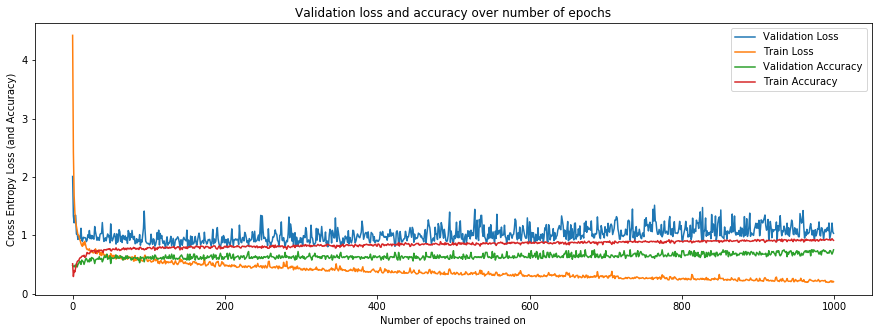

In [7]:
plt.subplots(figsize=(15,5))
plt.plot(loss_list); # blue
plt.plot(train_losses);
plt.plot(acc_list); # orange
plt.plot(train_accuracies);
plt.title('Validation loss and accuracy over number of epochs');
plt.xlabel('Number of epochs trained on');
plt.ylabel('Cross Entropy Loss (and Accuracy)');
plt.legend(['Validation Loss', 'Train Loss', 'Validation Accuracy', 'Train Accuracy'], loc='upper right');

In [8]:
# Test
model.eval()

total = 0
correct = 0
testlosses = []
correct_labels = []
predictions = []

with torch.no_grad():
    
    for batch_index, (images, labels) in enumerate(validation_loader):
        # Send to GPU (device)
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images.float())
        
        # Loss
        loss = criterion(outputs, labels)
        
        testlosses.append(loss.item())
        
        # Compute accuracy
        _, argmax = torch.max(outputs, 1)
        correct += (labels == argmax).sum().item() #.mean()
        total += len(labels)
        
        correct_labels.extend(labels)
        predictions.extend(argmax)
        

test_loss = np.mean(testlosses)
accuracy = np.round(correct/total, 2)
print(f'Loss: {test_loss:.4}, Acc: {accuracy:.2}')

Loss: 1.002, Acc: 0.75


In [9]:
from sklearn.metrics import confusion_matrix

y_true = [label.item() for label in correct_labels]
y_pred = [label.item() for label in predictions]

cm = confusion_matrix(y_true, y_pred)
# rows actual, cols pred
cm

array([[ 5,  1,  2],
       [ 2, 28,  4],
       [ 4,  4, 18]])

In [10]:
# distribution of validation data
pd.DataFrame({'label': y_true})['label'].value_counts()

1    34
2    26
0     8
Name: label, dtype: int64

In [11]:
from sklearn.metrics import classification_report

target_names = ['Amusement', 'Baseline', 'Stress']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Amusement       0.45      0.62      0.53         8
    Baseline       0.85      0.82      0.84        34
      Stress       0.75      0.69      0.72        26

   micro avg       0.75      0.75      0.75        68
   macro avg       0.68      0.71      0.69        68
weighted avg       0.76      0.75      0.76        68

